In [5]:
%load_ext blackcellmagic
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
import requests
import json
import data_import
import country_converter as coco
import plotly.graph_objects as go

# Internet Takeover

## CIA Factbook Analysis

We decided to explore how internet usage might affect different factors in countries. We hypothesized that internet usage would correlate to educational factors  We explored the CIA factbook to see if there was any fun trends we could find. W

In [7]:
rest_df = data_import.get_rest_countries()
cia_df = data_import.get_cia_data()
merged_data = pd.merge(rest_df, cia_df, how="inner", on="ISO3")
merged_data = merged_data[
    [
        "ISO3",
        "country_y",
        "region",
        "sub-region",
        "latitude",
        "longitude",
        "borders",
        "population",
        "internet_users",
        "internet_%_of_population",
        "median_age",
        "education_expenditures",
    ]
]
merged_data.head()

,ISO3,country_y,region,sub-region,latitude,longitude,borders,population,internet_users,internet_%_of_population,median_age,education_expenditures
0,AFG,Afghanistan,Asia,Southern Asia,33,65,"[IRN, PAK, TKM, UZB, TJK, CHN]",34940837.0,3531770.0,10.6,19.0,3.9
1,ALB,Albania,Europe,Southern Europe,41,20,"[MNE, GRC, MKD, KOS]",3057220.0,2016516.0,66.4,33.4,4.0
2,DZA,Algeria,Africa,Northern Africa,28,3,"[TUN, LBY, NER, ESH, MRT, MLI, MAR]",41657488.0,17291463.0,42.9,28.3,NaN
3,ASM,American Samoa,Oceania,Polynesia,-14.3333,-170,[],50826.0,17000.0,31.3,26.1,NaN
4,AND,Andorra,Europe,Southern Europe,42.5,1.5,"[FRA, ESP]",85708.0,83887.0,97.9,44.9,3.2


In [8]:
fig = go.Figure(
    data=go.Choropleth(
        locations=merged_data["ISO3"],
        z=merged_data["internet_%_of_population"],
        text=merged_data["country_y"],
        colorscale="Blues",
        autocolorscale=False,
        marker_line_color="darkgrey",
        marker_line_width=0.9,
        colorbar_title="Internet % of Population",
    )
)

fig.update_layout(
    title_text="Global Internet Usage by Country",
    geo=dict(showframe=False, showcoastlines=False, projection_type="equirectangular"),
    #     annotations = [dict(
    #         x=0.55,
    #         y=0.1,
    #         xref='paper',
    #         yref='paper',
    #         text='Source: <a href="https://www.cia.gov/library/publications/the-world-factbook/fields/2195.html">\
    #             CIA World Factbook</a>',
    #         showarrow = False
    #     )]
)

fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

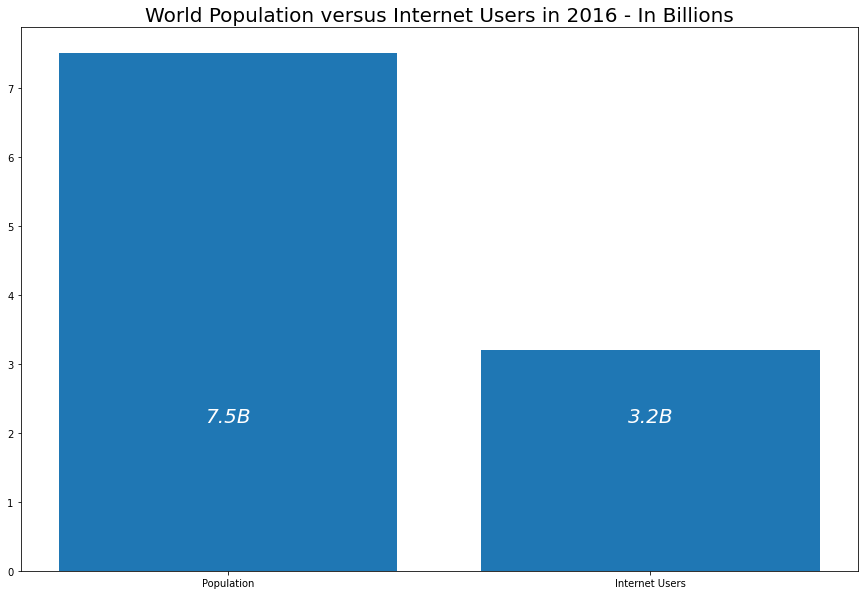

In [10]:
world = merged_data.loc[merged_data.ISO3.str.contains("World")]

# plot World Population versus Internet Users
world2 = merged_data.iloc[226]
round_population = round(world2.population / 1000000000, 1)
round_users = round(world2.internet_users / 1000000000, 1)
data = {"Population": round_population, "Internet Users": round_users}
names = list(data.keys())
values = list(data.values())
fig, axs = plt.subplots(1, 1, figsize=(15, 10), sharey=False)
plot = axs.bar(names, values)
plt.title("World Population versus Internet Users in 2016 - In Billions", fontsize=20)


def autolabel(rects):
    for idx, rect in enumerate(plot):
        height = rect.get_height() / abs(rect.get_height()) * 2
        axs.text(
            rect.get_x() + rect.get_width() / 2.0,
            1.05 * height,
            str(values[idx]) + "B",
            size="20",
            fontstyle="oblique",
            ha="center",
            va="bottom",
            rotation=0,
            color="white",
        )


autolabel(plot)

plt.show()

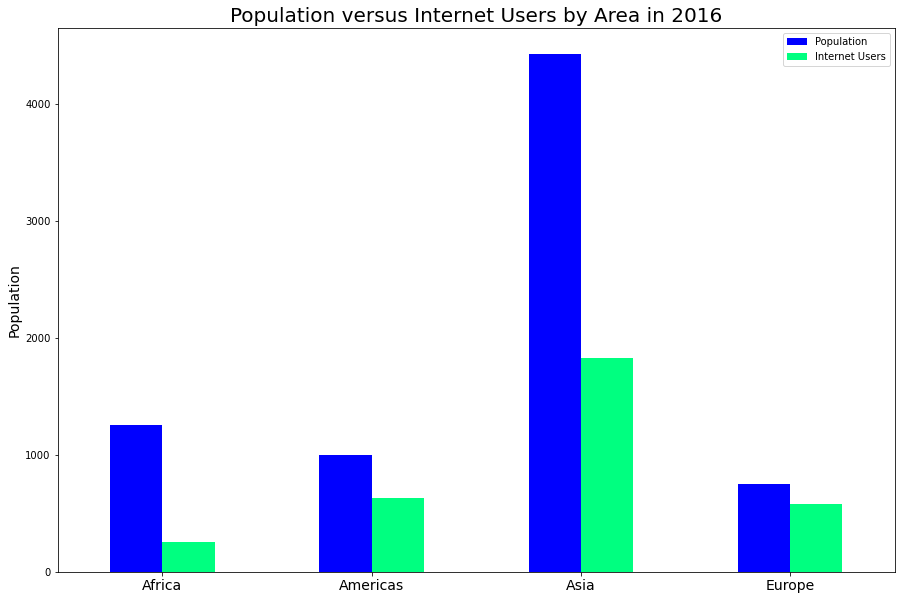

In [11]:
# Population versus Internet users by area
per_sub_area = (
    (merged_data[["region", "population", "internet_users"]]).groupby(["region"]).sum()
)
per_sub_area = per_sub_area.drop("World")
per_sub_area = per_sub_area.drop("Polar")
per_sub_area = per_sub_area.drop("Oceania")

per_sub_area = round(per_sub_area / 1000000, 2)
# plot
plot_2 = per_sub_area.plot(kind="bar", colormap="winter", figsize=(15, 10))
plt.title("Population versus Internet Users by Area in 2016", fontsize=20)
plt.ylabel("Population", fontsize=14)
plt.xlabel("")
plt.legend(["Population", "Internet Users"])
plt.xticks(rotation=0, fontsize=14)

plt.show()

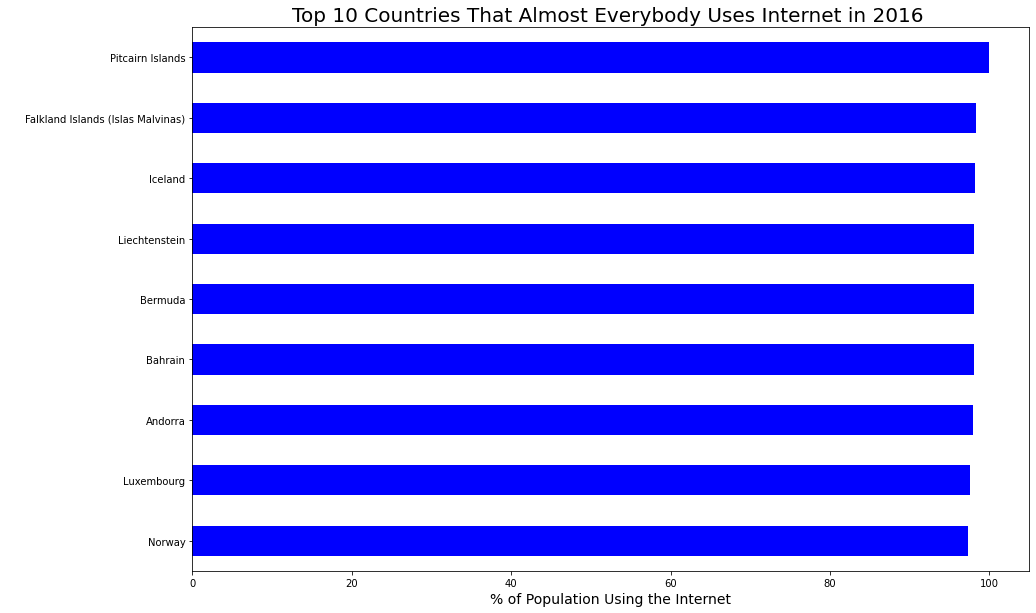

In [12]:
# What countries have almost 100% of their population using the Internet?
top_perc_internet_population = (
    merged_data[["country_y", "internet_%_of_population"]]
    .sort_values(by=["internet_%_of_population"], ascending=False)
    .head(10)
    .sort_values(by=["internet_%_of_population"], ascending=True)
    .set_index("country_y")
)

top_perc_internet_population = top_perc_internet_population.drop("Antarctica")

top_perc_internet_population.plot(
    kind="barh", legend=False, colormap="winter", figsize=(15, 10)
)
plt.title("Top 10 Countries That Almost Everybody Uses Internet in 2016 ", fontsize=20)
plt.xlabel("% of Population Using the Internet", fontsize=14)
plt.ylabel(" ", fontsize=14)
plt.show()

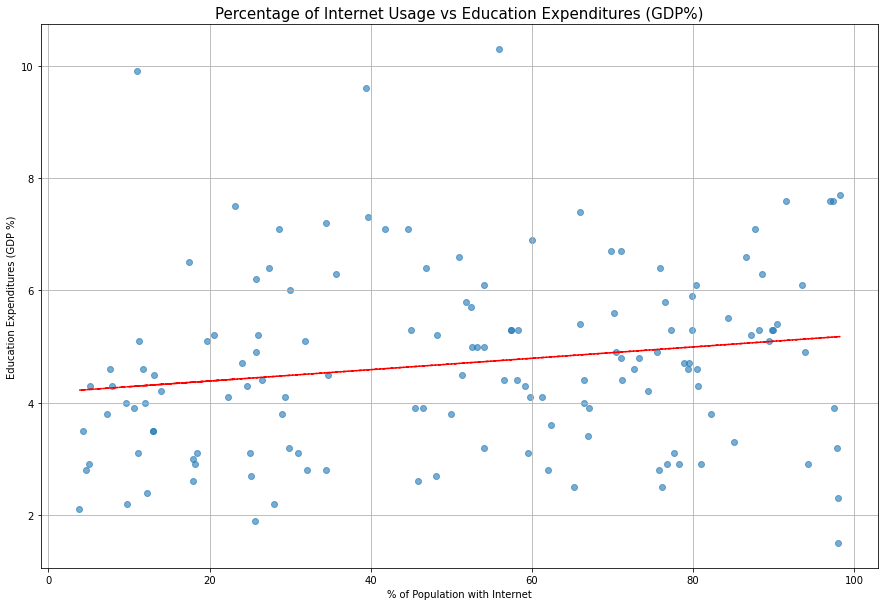

In [13]:
pop_low = merged_data["population"].quantile(0.1)
pop_hi = merged_data["population"].quantile(0.9)
edu_low = merged_data["education_expenditures"].quantile(0.01)
edu_hi = merged_data["education_expenditures"].quantile(0.99)


df_filtered = merged_data[
    (merged_data["population"] < pop_hi)
    & (merged_data["population"] > pop_low)
    & (merged_data["education_expenditures"] > edu_low)
    & (merged_data["education_expenditures"] < edu_hi)
]
z = np.polyfit(
    df_filtered["internet_%_of_population"], df_filtered["education_expenditures"], 1
)
p = np.poly1d(z)

# Plot to show Percentage of internet Usage vs Education Expenditures (GDP%)
plt.figure(figsize=(15, 10))
plt.plot(
    df_filtered["internet_%_of_population"],
    p(df_filtered["internet_%_of_population"]),
    "r--",
)
plt.scatter(
    df_filtered["internet_%_of_population"],
    df_filtered["education_expenditures"],
    alpha=0.6,
)
plt.title("Percentage of Internet Usage vs Education Expenditures (GDP%)", fontsize=15)
plt.xlabel("% of Population with Internet")
plt.ylabel("Education Expenditures (GDP %)")
plt.grid()

plt.savefig("Fig1.png")

# Show Figure
plt.show()

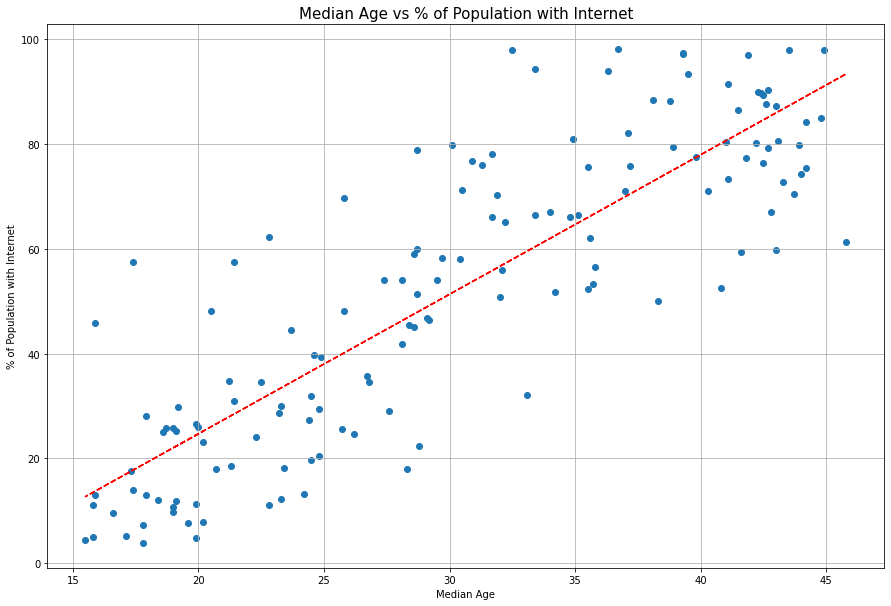

In [14]:
z_trend = np.polyfit(
    df_filtered["median_age"], df_filtered["internet_%_of_population"], 1
)
p_trend = np.poly1d(z_trend)

plt.figure(figsize=(15, 10))
plt.plot(df_filtered["median_age"], p_trend(df_filtered["median_age"]), "r--")
plt.scatter(df_filtered["median_age"], df_filtered["internet_%_of_population"])
plt.title("Median Age vs % of Population with Internet", fontsize=15)
plt.xlabel("Median Age")
plt.ylabel("% of Population with Internet")
plt.grid()

plt.savefig("Fig2.png")

plt.show()